In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [11]:
import sys
sys.path.append("../") 

from utils.paths import make_dir_line

modality = 'c'
project = 'Introduction to Relational Databases in SQL'
data = make_dir_line(modality, project)

raw = data('raw')

In [12]:
import sqlite3

conn = sqlite3.connect(":memory:")  ## aca se indica el nombre de la db.
cur = conn.cursor()

# 6.3.0_Uniquely identify records with key constraints

In [13]:
conn.executescript(
    """
    
    DROP TABLE IF EXISTS university_professors;

    CREATE TABLE university_professors (
        firstname             VARCHAR,
        lastname              VARCHAR,
        university            VARCHAR,
        university_shortname  VARCHAR,
        university_city       VARCHAR,
        function              VARCHAR,
        organization          VARCHAR,
        organization_sector   VARCHAR
    );


    DROP TABLE IF EXISTS professors;

    CREATE TABLE professors (
        firstname            text,
        lastname             text,
        university_shortname text
    );


    DROP TABLE IF EXISTS universities;
    
    CREATE TABLE universities (
        university_shortname text,
        university           text,
        university_city      text
    );


    DROP TABLE IF EXISTS affiliations;

    CREATE TABLE affiliations (
        firstname             text,
        lastname              text,
        function              text
    );


    DROP TABLE IF EXISTS organizations;

    CREATE TABLE organizations (
        organization        text,
        organization_sector text
    );
    
    
    DROP TABLE IF EXISTS cars;

    CREATE TABLE cars (
        make   varchar(64) NOT NULL,
        model  varchar(64) NOT NULL,
        mpg    integer NOT NULL
        
    );
    

    """
)
conn.commit()

In [16]:
df = pd.read_csv(raw / 'university_professors.csv', sep = ',', decimal = '.', header = 0, encoding = 'utf-8')
university_professors = list(zip(df.firstname, df.lastname, df.university, df.university_shortname, df.university_city, df.function, df.organization, df.organization_sector))
cur.executemany("INSERT INTO university_professors VALUES  (?,?,?,?,?,?,?,?)", university_professors)

df = pd.read_csv(raw / 'cars.csv', sep = ',', decimal = '.', header = 0, encoding = 'utf-8')
cars = list(zip(df.make, df.model, df.mpg))
cur.executemany("INSERT INTO cars VALUES  (?,?,?)", cars)

In [17]:
cur.executescript(
    """
    
    
    INSERT INTO universities 
    SELECT DISTINCT university_shortname, university, university_city 
    FROM university_professors;
    
    
    INSERT INTO professors 
    SELECT DISTINCT firstname, lastname, university_shortname 
    FROM university_professors;


    INSERT INTO affiliations 
    SELECT DISTINCT firstname, lastname, function
    FROM university_professors; 
    
    
    INSERT INTO organizations 
    SELECT DISTINCT organization, organization_sector 
    FROM university_professors; 
    

    """
)
conn.commit()

## 6.3.2 Get to know SELECT COUNT DISTINCT

In [18]:
# -- Count the number of rows in universities
cur.execute("""
            
            SELECT DISTINCT COUNT (*)
            FROM universities;
                        
            """).fetchall()

[(11,)]

In [19]:
# -- Count the number of distinct values in the university_city column
cur.execute("""
            
            SELECT COUNT(DISTINCT(university_city))
            FROM universities;
                        
            """).fetchall()

[(9,)]

## 6.3.3 Identify keys with SELECT COUNT DISTINCT

In [20]:
# # -- Try out different combinations
# cur.execute("""
            
#             SELECT COUNT(DISTINCT(firstname, lastname)) 
#             FROM professors;
                        
#             """).fetchall()


## 6.3.5 Identify the primary key

Which of the following column or column combinations could best serve as primary key?

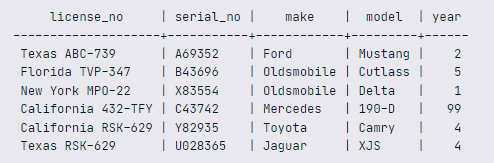

R:/ PK = {license_no}. A primary key consisting solely of "license_no" is probably the wisest choice, as license numbers are certainly unique across all registered cars in a country.

## 6.3.6 ADD key CONSTRAINTs to the tables

In [21]:
# -- Rename the organization column to id
cur.execute("""
            
            ALTER TABLE organizations
            RENAME COLUMN organization TO id;
                        
            """).fetchall()

[]

In [22]:
# # -- Make id a primary key
# cur.execute("""
            
#             ALTER TABLE organizations
#             ADD CONSTRAINT organization_pk PRIMARY KEY (id);
                        
#             """).fetchall()

In [23]:
# -- Rename the organization column to id
cur.execute("""
            
            ALTER TABLE universities
            RENAME COLUMN university_shortname TO id;
                        
            """).fetchall()

[]

In [24]:
# # -- Make id a primary key
# cur.execute("""
            
#             ALTER TABLE universities
#             ADD CONSTRAINT university_pk PRIMARY KEY (id);
                        
#             """).fetchall()

## 6.3.8 Add a SERIAL surrogate key

In [25]:
# -- Add the new column to the table
cur.execute("""
            
            ALTER TABLE professors 
            ADD COLUMN id serial;
                        
            """).fetchall()

[]

In [26]:
# # -- Make id a primary key
# cur.execute("""
            
#             ALTER TABLE professors 
#             ADD CONSTRAINT professors_pkey PRIMARY KEY (id);
                        
#             """).fetchall()

In [27]:
# -- Have a look at the first 10 rows of professors
cur.execute("""
            
            SELECT * 
            FROM professors 
            LIMIT 10;
                        
            """).fetchall()

[('Karl', 'Aberer', 'EPF', None),
 ('Reza Shokrollah', 'Abhari', 'ETH', None),
 ('Georges', 'Abou Jaoudé', 'EPF', None),
 ('Hugues', 'Abriel', 'UBE', None),
 ('Daniel', 'Aebersold', 'UBE', None),
 ('Christoph', 'Aebi', 'UBE', None),
 ('Marcelo', 'Aebi', 'ULA', None),
 ('Patrick', 'Aebischer', 'EPF', None),
 ('Stephan', 'Aier', 'USG', None),
 ('Anastasia', 'Ailamaki', 'EPF', None)]

## 6.3.9 CONCATenate columns to a surrogate key

In [32]:
# # -- Count the number of distinct rows with columns make, model
# cur.execute("""
            
#             SELECT COUNT(DISTINCT(make, model)) 
#             FROM cars;
                        
#             """).fetchall()

In [33]:
# -- Add the id column
cur.execute("""
            
            ALTER TABLE cars 
            ADD COLUMN id serial;
                        
            """).fetchall()

[]

In [35]:
# # -- Update id with make + model
# cur.execute("""
            
#             UPDATE cars
#             SET id = CONCAT(make, model);
                        
#             """).fetchall()

In [36]:
# # -- Make id a primary key
# cur.execute("""
            
#             ALTER TABLE cars
#             ADD CONSTRAINT id_pk PRIMARY KEY (id);
                        
#             """).fetchall()

In [37]:
# -- Have a look at the table
cur.execute("""
            
            SELECT * 
            FROM cars;
                        
            """).fetchall()

[('Subaru', 'Forester', 24, None),
 ('Opel', 'Astra', 45, None),
 ('Opel', 'Vectra', 40, None),
 ('Ford', 'Avenger', 30, None),
 ('Ford', 'Galaxy', 30, None),
 ('Toyota', 'Prius', 50, None),
 ('Toyota', 'Speedster', 30, None),
 ('Toyota', 'Galaxy', 20, None),
 ('Mitsubishi', 'Forester', 10, None),
 ('Mitsubishi', 'Galaxy', 30, None),
 ('Subaru', 'Forester', 24, None),
 ('Opel', 'Astra', 45, None),
 ('Opel', 'Vectra', 40, None),
 ('Ford', 'Avenger', 30, None),
 ('Ford', 'Galaxy', 30, None),
 ('Toyota', 'Prius', 50, None),
 ('Toyota', 'Speedster', 30, None),
 ('Toyota', 'Galaxy', 20, None),
 ('Mitsubishi', 'Forester', 10, None),
 ('Mitsubishi', 'Galaxy', 30, None)]

In [ ]:
cur.execute("""
            

                        
            """).fetchall()

[]

In [ ]:
print('Ok_')

Ok_
